<a href="https://colab.research.google.com/github/alexandrufalk/tensorflow/blob/Master/SRGAN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random


#Data Loading and Preprocessing

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
root_dir = "/content/drive/MyDrive/Datasets/BSDS500/images/"

In [30]:
# Paths
BASE_DIR = '/content/drive/MyDrive/Datasets/BSDS500/images/'
TRAIN_DIR = os.path.join(BASE_DIR, 'training')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')

In [104]:
# Parameters
CHANNELS = 3  # RGB
IMG_HEIGHT = 256
IMG_WIDTH = 256
SCALE_FACTOR = 2 # Downscaling factor for low-resolution images
AUTOTUNE = tf.data.AUTOTUNE

In [105]:
def load_and_preprocess_image(file_path):
    """
    Loads an image, resizes it to fixed dimensions, generates its low-resolution counterpart,
    and normalizes both images.

    Args:
        file_path (tf.Tensor): Path to the high-resolution image.

    Returns:
        tuple: (low-resolution image, high-resolution image)
    """
    try:
        # Read the image file
        image = tf.io.read_file(file_path)

        # Decode the image (supports JPEG, PNG, etc.)
        image = tf.image.decode_image(image, channels=CHANNELS, expand_animations=False)

        # Convert image to float32 tensor and normalize to [0, 1]
        image = tf.image.convert_image_dtype(image, tf.float32)

        # Resize high-resolution image to fixed dimensions
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH], method='bicubic')

        # Calculate low-resolution dimensions
        lr_height = IMG_HEIGHT // SCALE_FACTOR
        lr_width = IMG_WIDTH // SCALE_FACTOR

        # Resize to low-resolution using bicubic interpolation
        lr_image = tf.image.resize(image, [lr_height, lr_width], method='bicubic')

        # Normalize images to [-1, 1]
        hr_image = (image * 2.0) - 1.0
        lr_image = (lr_image * 2.0) - 1.0

        return lr_image, hr_image

    except tf.errors.InvalidArgumentError:
        # If image decoding fails, return zero tensors to be filtered out later
        lr_image = tf.zeros([IMG_HEIGHT // SCALE_FACTOR, IMG_WIDTH // SCALE_FACTOR, CHANNELS], dtype=tf.float32)
        hr_image = tf.zeros([IMG_HEIGHT, IMG_WIDTH, CHANNELS], dtype=tf.float32)
        return lr_image, hr_image

def augment(lr, hr):
    """
    Applies random horizontal and vertical flips to the low-resolution and high-resolution images.

    Args:
        lr (tf.Tensor): Low-resolution image tensor.
        hr (tf.Tensor): High-resolution image tensor.

    Returns:
        tuple: Augmented (low-resolution image, high-resolution image)
    """
    # Random horizontal flip
    flip_lr = tf.random.uniform([]) > 0.5
    flip_hr = tf.random.uniform([]) > 0.5

    lr = tf.cond(flip_lr, lambda: tf.image.flip_left_right(lr), lambda: lr)
    hr = tf.cond(flip_hr, lambda: tf.image.flip_left_right(hr), lambda: hr)

    # Random vertical flip
    flip_lr_v = tf.random.uniform([]) > 0.5
    flip_hr_v = tf.random.uniform([]) > 0.5

    lr = tf.cond(flip_lr_v, lambda: tf.image.flip_up_down(lr), lambda: lr)
    hr = tf.cond(flip_hr_v, lambda: tf.image.flip_up_down(hr), lambda: hr)

    return lr, hr

def create_dataset(directory, batch_size, augment_data=False):
    """
    Creates a TensorFlow dataset for SRGAN training with optional data augmentation.

    Args:
        directory (str): Directory containing high-resolution images.
        batch_size (int): Number of samples per batch.
        augment_data (bool, optional): Whether to apply data augmentation. Defaults to False.

    Returns:
        tf.data.Dataset: Prepared dataset ready for training.
    """
    # Define supported file extensions
    extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff']

    # Print the directory path to verify its correctness
    print(f"Checking directory: {directory}")

    # Create a list of file patterns
    file_patterns = [os.path.join(directory, ext) for ext in extensions]

    # List all files matching the patterns
    list_ds = tf.data.Dataset.list_files(file_patterns, shuffle=True)

    # Define the number of patches per image to increase dataset size
    num_patches_per_image = 5

    # Repeat each image multiple times to extract multiple patches
    list_ds = list_ds.repeat(num_patches_per_image)

    # Map the load_and_preprocess_image function to each file
    dataset = list_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    # Filter out zero tensors resulting from failed image decoding
    def filter_invalid(lr, hr):
        return tf.reduce_sum(tf.abs(lr)) > 0 and tf.reduce_sum(tf.abs(hr)) > 0

    dataset = dataset.filter(filter_invalid)

    # Apply data augmentation if specified
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=AUTOTUNE)

    # Shuffle, batch, and prefetch
    if augment_data:
        # Shuffle before batching to ensure augmented samples are mixed
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

#Preprocessing Each Dataset

Checking directory: /content/drive/MyDrive/Datasets/BSDS500/images/training
Checking directory: /content/drive/MyDrive/Datasets/BSDS500/images/validation
Checking directory: /content/drive/MyDrive/Datasets/BSDS500/images/test
LR batch shape: (16, 128, 128, 3)
HR batch shape: (16, 256, 256, 3)


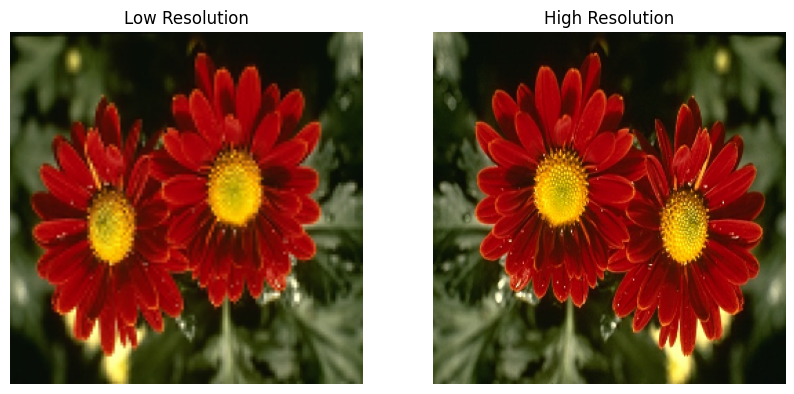

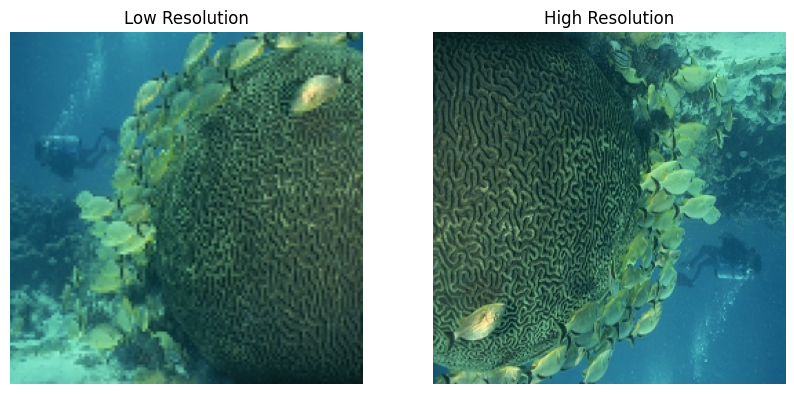

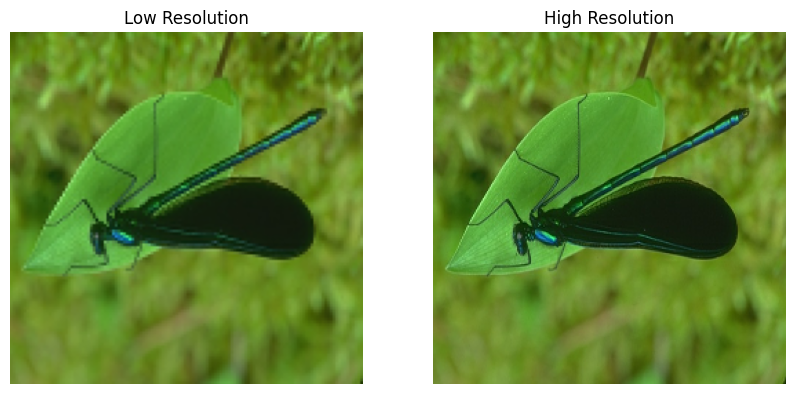

In [106]:
# Define hyperparameters
BATCH_SIZE = 16
HR_PATCH_SIZE = IMG_HEIGHT  # 96
LR_SCALE = SCALE_FACTOR    # 4

# Create datasets
train_dataset = create_dataset(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    augment_data=True  # Enable augmentation for training
)

val_dataset = create_dataset(
    directory=VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    augment_data=False  # Disable augmentation for validation
)

test_dataset = create_dataset(
    directory=TEST_DIR,
    batch_size=BATCH_SIZE,
    augment_data=False  # Disable augmentation for testing
)

# Verify the datasets by iterating through a batch
for lr_batch, hr_batch in train_dataset.take(1):
    print(f"LR batch shape: {lr_batch.shape}")  # Expected: (16, 24, 24, 3)
    print(f"HR batch shape: {hr_batch.shape}")  # Expected: (16, 96, 96, 3)")

    # Visualize the first 3 images in the batch
    for i in range(3):
        lr_img = (lr_batch[i].numpy() + 1.0) * 127.5
        lr_img = np.clip(lr_img, 0, 255).astype(np.uint8)

        hr_img = (hr_batch[i].numpy() + 1.0) * 127.5
        hr_img = np.clip(hr_img, 0, 255).astype(np.uint8)

        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.title('Low Resolution')
        plt.imshow(lr_img)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title('High Resolution')
        plt.imshow(hr_img)
        plt.axis('off')

        plt.show()

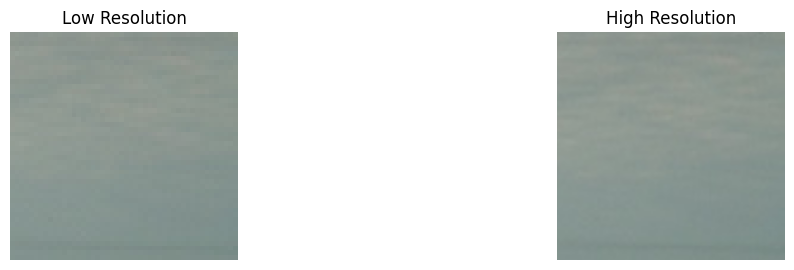

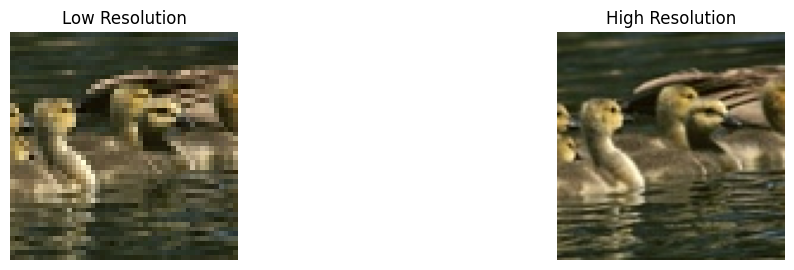

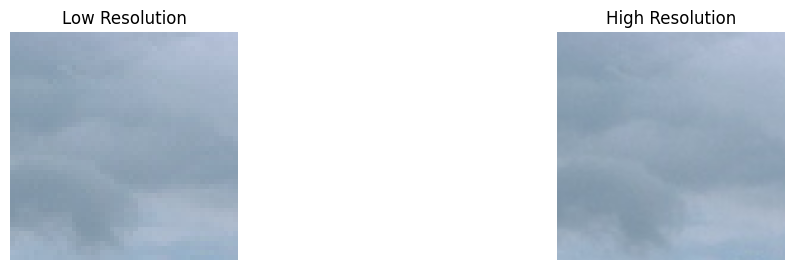

In [59]:
import matplotlib.pyplot as plt

def denormalize(img):
    img = (img + 1.0) * 127.5
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

# Example visualization
for lr, hr in train_dataset.take(1):
    for i in range(3):  # Display first 3 images in the batch
        plt.figure(figsize=(10,4))

        plt.subplot(1, 3, 1)
        plt.title('Low Resolution')
        plt.imshow(denormalize(lr[i].numpy()))
        plt.axis('off')



        plt.subplot(1, 3, 3)
        plt.title('High Resolution')
        plt.imshow(denormalize(hr[i].numpy()))
        plt.axis('off')

        plt.show()


#Define the Generator
-residual blocks and upsampling layers to convert low-resolution images to high-resolution images.

-A residual block helps in training deeper networks by allowing gradients to flow through skip connections.

In [32]:
def residual_block(input_tensor, filters=64, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_tensor])
    return x

#Upsampling Block
Uses PixelShuffle (sub-pixel convolution) to upscale the image.


In [33]:
def upsample_block(input_tensor, filters=256, kernel_size=3, scale=2):
    x = layers.Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = layers.Lambda(lambda x: tf.nn.depth_to_space(x, scale))(x)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    return x

#Generator Model

In [34]:
def build_generator(hr_shape):
    """
    Args:
        hr_shape: tuple, high-resolution image shape, e.g., (None, None, 3)
    Returns:
        Keras Model
    """
    inputs = layers.Input(shape=(None, None, 3))

    # Initial Conv layer
    x = layers.Conv2D(64, 9, padding='same')(inputs)
    x = layers.PReLU(shared_axes=[1, 2])(x)
    residual = x

    # 16 Residual blocks
    for _ in range(16):
        residual = residual_block(residual)

    # Conv layer after residual blocks
    x = layers.Conv2D(64, 3, padding='same')(residual)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, inputs])

    # Upsampling blocks
    x = upsample_block(x)
    x = upsample_block(x)

    # Output layer
    outputs = layers.Conv2D(3, 9, padding='same', activation='tanh')(x)

    model = models.Model(inputs, outputs, name='Generator')
    return model

#Define the Discriminator
The discriminator is a CNN that classifies images as real or fake.

In [35]:
def build_discriminator(hr_shape):
    """
    Args:
        hr_shape: tuple, high-resolution image shape, e.g., (None, None, 3)
    Returns:
        Keras Model
    """
    inputs = layers.Input(shape=hr_shape)

    x = layers.Conv2D(64, 3, strides=1, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # 15 Convolutional blocks
    filters = 64
    for i in range(1, 16):
        if i % 2 == 0:
            strides = 2
            filters *= 2
        else:
            strides = 1
        x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name='Discriminator')
    return model

In [36]:
# Load pre-trained VGG19 model + higher level layers
def build_vgg():
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=(None, None, 3))
    vgg.trainable = False
    # Select the output of 'block5_conv4' for perceptual loss
    output = vgg.get_layer('block5_conv4').output
    model = models.Model(vgg.input, output)
    return model

vgg = build_vgg()




#Perceptual Loss
Uses feature maps from a pre-trained VGG19 network to compute the loss.

In [37]:
def content_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def perceptual_loss(y_true, y_pred):
    y_true_features = vgg(y_true)
    y_pred_features = vgg(y_pred)
    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

#Define the SRGAN Model

Combines the generator and discriminator. The discriminator is used to compute the adversarial loss for the generator.

In [38]:
def build_srgan(generator, discriminator, vgg):
    """
    Args:
        generator: Keras Model, generator model
        discriminator: Keras Model, discriminator model
        vgg: Keras Model, pre-trained VGG model for perceptual loss
    Returns:
        Keras Model
    """
    discriminator.trainable = False
    sr = generator.output
    vgg_features = vgg(sr)
    validity = discriminator(sr)

    model = models.Model(generator.input, [validity, vgg_features])
    return model


#Define Loss Functions
Mean Squared Error between the generated image and the ground truth high-resolution image.

In [39]:
#Adversarial Loss - Binary cross-entropy loss to train the generator to fool the discriminator.
adversarial_loss = tf.keras.losses.BinaryCrossentropy()

#Training the SRGAN
The training process involves alternating between training the discriminator and the generator.

In [40]:
@tf.function
def train_step(generator, discriminator, vgg, lr, hr,
               generator_optimizer, discriminator_optimizer):
    with tf.GradientTape(persistent=True) as tape:
        # Generate high-resolution images
        sr = generator(lr, training=True)

        # Discriminator predictions
        real_validity = discriminator(hr, training=True)
        fake_validity = discriminator(sr, training=True)

        # Calculate losses
        # Generator adversarial loss
        g_adv = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_validity), fake_validity)

        # Generator content loss
        g_content = tf.reduce_mean(tf.square(hr - sr))

        # Generator perceptual loss
        sr_vgg = vgg(sr)
        hr_vgg = vgg(hr)
        g_perc = tf.reduce_mean(tf.square(hr_vgg - sr_vgg))

        # Total generator loss
        g_total = g_content + 1e-3 * g_perc + 1e-3 * g_adv

        # Discriminator loss
        d_real = tf.keras.losses.binary_crossentropy(tf.ones_like(real_validity), real_validity)
        d_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_validity), fake_validity)
        d_total = (d_real + d_fake) / 2

    # Calculate gradients
    gradients_generator = tape.gradient(g_total, generator.trainable_variables)
    gradients_discriminator = tape.gradient(d_total, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))

    return g_total, d_total

In [41]:
# Training loop
def train_srgan(generator, discriminator, srgan, vgg,
               lr_images, hr_images, epochs, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((lr_images, hr_images))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for step, (lr, hr) in enumerate(dataset):
            g_loss, d_loss = train_step(generator, discriminator, vgg, lr, hr,
                                       generator_optimizer, discriminator_optimizer)
            if step % 100 == 0:
                print(f"Step {step}: Generator loss: {g_loss.numpy()}, Discriminator loss: {d_loss.numpy()}")
        # Optionally, save models or generate sample images here